<a href="https://colab.research.google.com/github/Pooret/drug-discovery-ml/blob/main/de_novo_drug_generation_with_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!pip install bertviz
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
import pandas as pd
import numpy as np

import re
import math
import torch
import os

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, RobertaModel, RobertaTokenizer, pipeline

from tqdm import tqdm
import matplotlib.pyplot as plt

from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
from bertviz import head_view


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


### [ChEMBLdb](https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/)

In [5]:
df_full = pd.read_csv("/content/data.csv")
df_full.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 38 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   molregno                     1000000 non-null  int64  
 1   canonical_smiles             1000000 non-null  object 
 2   activity_id                  1000000 non-null  int64  
 3   standard_type                1000000 non-null  object 
 4   standard_value               996526 non-null   float64
 5   standard_units               1000000 non-null  object 
 6   assay_id                     1000000 non-null  int64  
 7   tid                          1000000 non-null  int64  
 8   target_chembl_id             1000000 non-null  object 
 9   organism                     965456 non-null   object 
 10  pref_name                    1000000 non-null  object 
 11  mw_freebase                  1000000 non-null  float64
 12  alogp                        984990 non-nul

In [7]:
selected_cols =[
              'canonical_smiles',
              'standard_type',
              'standard_value',
              'standard_units',
              'alogp',
              'mw_freebase',
              'hba',
              'hbd',
              'psa',
              'num_ro5_violations',
]
df_full[selected_cols].head()

,canonical_smiles,standard_type,standard_value,standard_units,alogp,mw_freebase,hba,hbd,psa,num_ro5_violations
0,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,IC50,110.0,nM,9.29,606.86,2.0,2.0,31.82,2.0
1,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,Potency,73078.0,nM,4.50,317.18,2.0,0.0,26.30,0.0
2,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,IC50,30.0,nM,4.54,364.18,2.0,0.0,26.30,0.0
3,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,IC50,95.0,nM,3.78,262.31,2.0,0.0,26.30,0.0
4,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,IC50,190.0,nM,4.54,364.18,2.0,0.0,26.30,0.0


In [8]:
df_full[df_full['standard_type'].isin(['EC50', 'IC50', 'Potency'])]['standard_value'].describe()

count    7.686380e+05
mean     5.223123e+18
std      1.550537e+21
min     -8.200000e+04
25%      5.200000e+03
50%      3.981070e+04
75%      8.912510e+04
max      8.912509e+23
Name: standard_value, dtype: float64

In [9]:
df_full['standard_type'].unique()

array(['IC50', 'Potency', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Cmax', 'Selectivity', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'T-cell', 'MCC', 'CC50', 'EC50', 'Kb', 'Relative IC50',
       'pKi', 'TGI', 'pA2', 'IC95', 'TC50', 'Ke', 'Inhibition', 'Ratio',
       'ID50', 'Kis', 'fCmax', 'MIC90', 'IC90', 'AC50', 'ED50', 'Log Ki',
       'T50', 'T max', 'Kieq', 'K bind', 'P-450 loss', 'Activity', 'IC30',
       'dP/dt', 'fIC30', 'Protection', 'Stability', 'Kd2', 'KiAH', 'C50',
       'TD50', 'Ri', 'Plasmaconcentration', 'Plasma concentration', 'MEC',
       'Rate', 'Ratio Ki', 'Binding affinity', 'Plasma level', 'ED20',
       'pEC50', 'cKi', 'K0.5', 'Synergy EC50', 'fEC50', 'MIC100', 'CIC',
       'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH', 'Residual activity',
       'Dose', 'Estrogenic effect', 'Ki0', 'MI0.5', 'Ks', 'K 0.5',
       'PT extension', 'Cytotoxicity', 'K app', 'Synergy', 'KL', 'IC60',
       'Log IC50', 'Kif', 'Ki ss', 'SC200', 'EC20', 'KiH', '

In [10]:
# Filter for specific metrics
df_clean = df_full[df_full['standard_type'].isin(['EC50', 'IC50', 'Potency'])]

# Remove negative values
df_clean = df_clean[df_clean['standard_value'] > 0]

# Remove values above a specific threshold
threshold_upper = df_clean['standard_value'].quantile(0.5)
df_clean = df_clean[df_clean['standard_value'] <= threshold_upper]

# Remove compounds that violate any of lipinski's 5 rules of drug-likeness (Consider removing this for more chemical diversity)
df_clean = df_clean[df_clean['num_ro5_violations'] < 1][selected_cols]
df_clean

,canonical_smiles,standard_type,standard_value,standard_units,alogp,mw_freebase,hba,hbd,psa,num_ro5_violations
2,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,IC50,30.0000,nM,4.54,364.18,2.0,0.0,26.30,0.0
3,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,IC50,95.0000,nM,3.78,262.31,2.0,0.0,26.30,0.0
4,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,IC50,190.0000,nM,4.54,364.18,2.0,0.0,26.30,0.0
5,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,IC50,0.5129,nM,2.68,433.51,7.0,1.0,93.81,0.0
6,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,IC50,33.8800,nM,1.80,435.53,9.0,1.0,110.88,0.0
...,...,...,...,...,...,...,...,...,...,...
999957,COc1ccc2c(c1OC(=O)/C=C/c1ccccc1)CN1CCc3cc4c(cc...,IC50,3.7500,nM,4.70,455.51,6.0,0.0,57.23,0.0
999959,COc1ccc2c(c1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O...,IC50,10000.0000,nM,0.26,487.51,10.0,4.0,130.31,0.0
999960,COc1ccc2c(c1O[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O...,IC50,10000.0000,nM,0.26,487.51,10.0,4.0,130.31,0.0
999963,COc1cc2c(cc1OC)C1Cc3ccc(OC)c(O)c3CN1CC2,IC50,3110.0000,nM,3.07,341.41,5.0,1.0,51.16,0.0


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260489 entries, 2 to 999965
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   canonical_smiles    260489 non-null  object 
 1   standard_type       260489 non-null  object 
 2   standard_value      260489 non-null  float64
 3   standard_units      260489 non-null  object 
 4   alogp               260489 non-null  float64
 5   mw_freebase         260489 non-null  float64
 6   hba                 260489 non-null  float64
 7   hbd                 260489 non-null  float64
 8   psa                 260489 non-null  float64
 9   num_ro5_violations  260489 non-null  float64
dtypes: float64(7), object(3)
memory usage: 21.9+ MB


In [12]:
df_clean.shape

(260489, 10)

In [13]:
df_clean = df_clean.drop_duplicates(subset='canonical_smiles', keep='first')
df_clean.shape

(260485, 10)

$ℒ(x;θ,ϕ) = {\mathbb{E}}_{q_ϕ(z|x)}[\log p_{\theta}(x|z)] - D_{KL}(q_{\phi}(z|x)||p(z))$

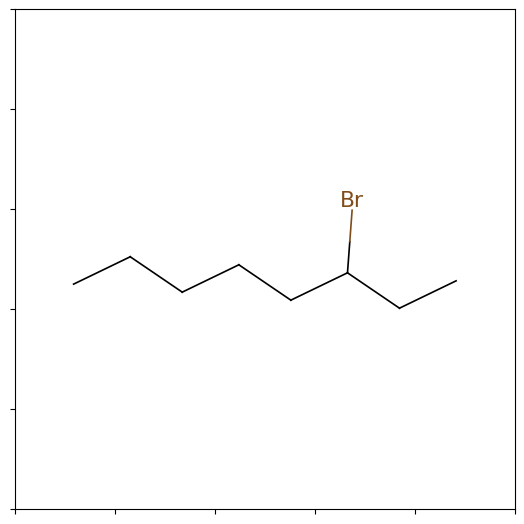

In [14]:
m = Chem.MolFromSmiles('CCCCCC(Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

In [28]:
class SMILESDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        smiles = self.dataframe.iloc[idx]['canonical_smiles']
        # You can also load other properties if you plan to use them as labels
        # For example:
        # property_value = self.dataframe.iloc[idx]['standard_value']
        # return {"smiles": smiles, "property": property_value}
        return smiles

class ChemVAE(nn.Module):
    def __init__(self, vocab_size, chemberta_model_name="DeepChem/ChemBERTa-77M-MTR", d_model=384, num_layers=3, dropout=0.1):
        super(ChemVAE, self).__init__()
        self.encoder = Encoder(chemberta_model_name, d_model)
        self.decoder = Decoder(vocab_size, d_model, num_layers, dropout)

    def forward(self, input_ids, attention_mask):
        mu, logvar = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        z = self.encoder.reparameterize(mu, logvar)
        reconstruction, hidden_state = self.decoder(z)
        return reconstruction, mu, logvar, hidden_state


class Encoder(nn.Module):
    def __init__(self, chemberta_model_name, d_model):
        super(Encoder, self).__init__()
        self.chemberta = AutoModelForMaskedLM.from_pretrained(chemberta_model_name)
        self.transformer_encoder = self.chemberta.roberta

        self.mean_linear = nn.Linear(d_model, d_model)
        self.logvar_linear = nn.Linear(d_model, d_model)

    def forward(self, input_ids, attention_mask):

        outputs = self.transformer_encoder(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state

        # Use the CLS token (first token) for VAE
        cls_token_state = last_hidden_state[:, 0, :]

        # Calculate mean and log variance for the latent space
        mu = self.mean_linear(cls_token_state)
        logvar = self.logvar_linear(cls_token_state)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model=384, num_layers=4, dropout=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.fc = nn.Linear(d_model, d_model)  # First layer to handle continuous latent vector
        self.grus = nn.ModuleList([nn.GRU(d_model, d_model, num_layers=1, batch_first=True, dropout=(dropout if i < num_layers - 1 else 0)) for i in range(num_layers)])
        self.multihead_attention = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        self.output_fc = nn.Linear(d_model, vocab_size)  # Output layer


    def forward(self, z, hidden=None, encoder_outputs=None):
        if hidden is None:
            hidden = [None] * self.num_layers

        x = self.fc(z)  # Treat z as continuous and map it
        x = x.unsqueeze(1)  # Add sequence length dimension for RNN and Attention compatibility

        for i, gru in enumerate(self.grus):
            x, hidden[i] = gru(x, hidden[i])

        # Applying multi-head attention (if using encoder outputs, ensure they are correctly dimensioned and passed)
        x = x.permute(1, 0, 2)  # Adjusting dimensions for multi-head attention
        attn_output, _ = self.multihead_attention(x, x, x)  # Self-attention or encoder-decoder attention
        attn_output = attn_output.permute(1, 0, 2)

        x = self.output_fc(x + attn_output)  # Final output layer
        return x.squeeze(1), hidden



In [25]:
# implementation
import os

dataset = SMILESDataset(df_clean)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = Encoder(chemberta_model_name="DeepChem/ChemBERTa-77M-MTR", d_model=384).to(device)
decoder = Decoder(tokenizer.vocab_size).to(device)

# Optimizer and a Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1

for epoch in range(num_epochs):
    for smiles in dataloader:
        #optimizer.zero_grad()
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        mu, logvar = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        z = model.reparameterize(mu, logvar)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Compute reconstruction loss here and combine with KL loss
        loss = kl_loss  # Define target appropriately
        #loss.backward()
        #optimizer.step()
    print(f"Epoch {epoch+1} completed")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1 completed


In [29]:
decoder = Decoder(tokenizer.vocab_size).to(device)

In [31]:
outputs = decoder(z)

In [32]:
outputs[0].shape

torch.Size([5, 5, 591])

In [37]:
outputs[1][1].shape

torch.Size([1, 5, 384])

In [82]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Initialize the dataset and dataloader
dataset = SMILESDataset(df_clean)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = ChemVAE(chemberta_model_name="DeepChem/ChemBERTa-77M-MTR", d_model=384, vocab_size=tokenizer.vocab_size).to(device)

# Optimizer and loss function setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reconstruction_loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for smiles in dataloader:
        #optimizer.zero_grad()

        # Tokenize input and prepare target tensor
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        target = inputs['input_ids']  # Assuming you want to reconstruct the input

        # Model forward pass
        reconstruction, mu, logvar, hidden_state = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # KL divergence and reconstruction loss calculation
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        reconstruction_loss = reconstruction_loss_fn(reconstruction, target)
        loss = reconstruction_loss + kl_loss

        # # Backpropagation
        # loss.backward()
        # optimizer.step()

        print(f"Epoch {epoch+1} completed")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [73]:
# implementation
import os


def kl_divergence(logvar, mean):
  return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

dataset = SMILESDataset(df_clean)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = ChemVAE(chemberta_model_name="DeepChem/ChemBERTa-77M-MTR", d_model=384, vocab_size = tokenizer.vocab_size).to(device)


# Optimizer and a Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
reconstruction_loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 1

for epoch in range(num_epochs):
    for smiles in dataloader:
        optimizer.zero_grad()
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        reconstruction, mu, logvar, hidden_state = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Compute reconstruction loss here and combine with KL loss
        loss = reconstruction_loss_fn(reconstruction, target) + kl_loss  # Define target appropriately
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed")


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [85]:
%%time
# implementation

def vae_loss(x, x_recon, mean, logvar, beta):
    # Reconstruction loss
    recon_loss = F.cross_entropy(x_recon.view(-1, x_recon.size(-1)), x.view(-1), ignore_index=vocab['<pad>'], reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Total VAE loss
    loss = recon_loss + beta * kl_loss

    return loss, recon_loss, kl_loss

dataset = SMILESDataset(df_clean)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Encoder(chemberta_model_name="DeepChem/ChemBERTa-77M-MTR", d_model=384).to(device)

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

num_epochs=1
for epoch in range(num_epochs):
    for smiles in dataloader:
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs.to(device))
        # Compute your loss function here
        # Perform backpropagation and optimizer steps
        # loss.backward()
        # optimizer.step()
    print(f"Epoch {epoch+1} completed")
    print(outputs.shape)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
outputs[0].shape

torch.Size([5, 384])

In [23]:
outputs[1].shape

torch.Size([5, 384])

In [80]:
%%time

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

N = 1
smiles = df_clean['canonical_smiles'].iloc[0]
print('Len of smiles string:',len(smiles))
print(smiles)
with torch.no_grad():
    padding=True
    encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
    model_output = chemberta(**encoded_input)
    print()
    print('model_output:')
    print('model_output info - type:', type(model_output),'len(model_output)', len(model_output) ,)
    print('type( model_output[0]):', type( model_output[0]), 'model_output[0].shape:',  model_output[0].shape  )
    print('model_output - first 100 symbols', str( model_output)[:100] )
    print()

    embedding = model_output[0][:,0,:]
    embeddings_cls = embedding
    print('embeddings_cls: type', type(embeddings_cls), 'shape:', embeddings_cls.shape)
    print()

    embedding = torch.mean(model_output[0],1)
    embeddings_mean = embedding
    print('embeddings_mean: type', type(embeddings_mean), 'shape:', embeddings_mean.shape)
    print()

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Len of smiles string: 31
O=C1O/C(=C/I)CCC1c1cccc2ccccc12

model_output:
model_output info - type: <class 'transformers.modeling_outputs.MaskedLMOutput'> len(model_output) 1
type( model_output[0]): <class 'torch.Tensor'> model_output[0].shape: torch.Size([1, 33, 600])
model_output - first 100 symbols MaskedLMOutput(loss=None, logits=tensor([[[-0.4940,  0.0000,  0.7024,  ...,  0.7174, -0.0010, -0.522

embeddings_cls: type <class 'torch.Tensor'> shape: torch.Size([1, 600])

embeddings_mean: type <class 'torch.Tensor'> shape: torch.Size([1, 600])

CPU times: user 270 ms, sys: 6.02 ms, total: 276 ms
Wall time: 354 ms


In [76]:
model_output[:100][0][0].shape

torch.Size([33, 600])

In [62]:

from transformers import AutoTokenizer
model_checkpoint = "DeepChem/ChemBERTa-77M-MTR"
model = RobertaModel.from_pretrained(model_checkpoint, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
# model = RobertaModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

head_view(attention, tokens)

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

In [59]:
# Define the regex pattern (from Schwaller et. al https://pubs.acs.org/doi/10.1021/acscentsci.9b00576)
TOKEN_PATTERN = "(\\[[^\\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\\(|\\)|\\.|=|\n#|-|\\+|\\\\|\\/|:|~|@|\\?|>>?|\\*|\\$|\\%[0-9]{2}|[0-9])"

TOKEN_REGEX = re.compile(TOKEN_PATTERN)

def create_vocabulary(smiles_list):
    tokens = set()
    for s in smiles_list:
        tokens.update(re.findall(TOKEN_PATTERN, s))

    tokens = sorted(list(tokens))
    vocab = {token: idx + 1 for idx, token in enumerate(tokens)}
    vocab["<pad>"] = 0
    vocab["<start>"] = len(vocab)
    vocab["<end>"] = len(vocab) + 1
    return vocab

def tokenize_smiles(smiles, vocab, tokenizer):
    tokens = ["<start>"] + TOKEN_REGEX.findall(smiles) + ["<end>"]
    return [vocab[token] for token in tokens]



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len
        self.d_model = d_model

    def forward(self, x):
        position = torch.arange(x.size(0)).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2) * -(math.log(10000.0) / self.d_model))
        pe = torch.zeros(x.size(0), self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        x = x + pe[:x.size(0), :]
        return self.dropout(x)

class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.d_model = d_model
        self.mean_linear = nn.Linear(d_model, d_model)
        self.logvar_linear = nn.Linear(d_model, d_model)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        mean = self.mean_linear(output)
        logvar = self.logvar_linear(output)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout=0.1):
        """

        Args:
          vocab_size:
          d_model:
          num_layers:
          dropout:
        """
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

        # GRU layers
        self.grus = nn.ModuleList([nn.GRU(d_model, d_model, num_layers=1, batch_first=True, dropout=dropout) for _ in range(num_layers)])
        self.attention = nn.MultiheadAttention(d_model, num_heads=8, dropout=dropout)
        self.fc = nn.Linear(d_model, vocab_size)
        self.start_token_index = vocab['<start>']
        self.end_token_index = vocab['<end>']
        self.max_length = 100

    def forward(self, x, hidden, encoder_outputs, mode='train'):
        if mode == 'train':
            x = self.embedding(x)
            for gru in self.grus:
                x, hidden = gru(x, hidden)
            x = x.permute(1, 0, 2)
            attn_output, _ = self.attention(x, encoder_outputs, encoder_outputs)
            attn_output = attn_output.permute(1, 0, 2)
            x = x.permute(1, 0, 2) + attn_output
            x = self.fc(x)
            return x, hidden
        elif mode == 'generate':
            input = torch.tensor([[self.start_token_index]], device=x.device)
            outputs = []
            for i in range(self.max_length):
                x = self.embedding(input)
                for gru in self.grus:
                    x, hidden = gru(x, hidden)
                x = x.permute(1, 0, 2)
                attn_output, _ = self.attention(x, encoder_outputs, encoder_outputs)
                attn_output = attn_output.permute(1, 0, 2)
                x = x.permute(1, 0, 2) + attn_output
                x = self.fc(x.squeeze(0))
                topv, topi = x.topk(1)
                input = topi.squeeze().detach()
                if input.item() == self.end_token_index:
                    break
                outputs.append(input)
            return torch.stack(outputs, dim=0)

In [60]:
for i in range(5):
  print(f"canonical smiles: {df_clean['canonical_smiles'].iloc[i]}")
  print(f"tokenized smiles: {TOKEN_REGEX.findall(df_clean['canonical_smiles'].iloc[i])}")

canonical smiles: O=C1O/C(=C/I)CCC1c1cccc2ccccc12
tokenized smiles: ['O', '=', 'C', '1', 'O', '/', 'C', '(', '=', 'C', '/', 'I', ')', 'C', 'C', 'C', '1', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']
canonical smiles: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1
tokenized smiles: ['C', 'C', '/', 'C', '=', 'C', '1', '\\', 'C', 'C', 'C', '(', 'c', '2', 'c', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', 'c', '2', '3', ')', 'C', '(', '=', 'O', ')', 'O', '1']
canonical smiles: O=C1O/C(=C\I)CCC1c1cccc2ccccc12
tokenized smiles: ['O', '=', 'C', '1', 'O', '/', 'C', '(', '=', 'C', '\\', 'I', ')', 'C', 'C', 'C', '1', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']
canonical smiles: COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2cc1OC
tokenized smiles: ['C', 'O', 'c', '1', 'c', 'c', '2', 'n', 'c', '(', 'N', '3', 'C', 'C', 'N', '(', 'C', '(', '=', 'O', ')', 'C', '4', 'C', 'C', '4', 'c', '4', 'c', 'c', 'c', 'c', 'c', '4', ')', 'C', 'C', '3', ')', 'n', 'c', '(', 'N', ')'

In [61]:
from transformers import AutoTokenizer
model_checkpoint = 'DeepChem/ChemBERTa-77M-MTR'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
for i in range(5):
  print(f"canonical smiles: {df_clean['canonical_smiles'].iloc[i]}")
  print(tokenizer.tokenize(df_clean['canonical_smiles'].iloc[i]))

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

canonical smiles: O=C1O/C(=C/I)CCC1c1cccc2ccccc12
['O', '=', 'C', '1', 'O', '/', 'C', '(', '=', 'C', '/', 'I', ')', 'C', 'C', 'C', '1', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']
canonical smiles: C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1
['C', '#', 'C', '/', 'C', '=', 'C', '1', '\\', 'C', 'C', 'C', '(', 'c', '2', 'c', 'c', 'c', 'c', '3', 'c', 'c', 'c', 'c', 'c', '2', '3', ')', 'C', '(', '=', 'O', ')', 'O', '1']
canonical smiles: O=C1O/C(=C\I)CCC1c1cccc2ccccc12
['O', '=', 'C', '1', 'O', '/', 'C', '(', '=', 'C', '\\', 'I', ')', 'C', 'C', 'C', '1', 'c', '1', 'c', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '1', '2']
canonical smiles: COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2cc1OC
['C', 'O', 'c', '1', 'c', 'c', '2', 'n', 'c', '(', 'N', '3', 'C', 'C', 'N', '(', 'C', '(', '=', 'O', ')', 'C', '4', 'C', 'C', '4', 'c', '4', 'c', 'c', 'c', 'c', 'c', '4', ')', 'C', 'C', '3', ')', 'n', 'c', '(', 'N', ')', 'c', '2', 'c', 'c', '1', 'O', 'C']
canonical smiles: COc1cc2nc(N3

In [ ]:
from transformers import AutoTokenizer
model_checkpoint = 'DeepChem/ChemBERTa-77M-MTR'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
test_smiles = 'CCC1=[O+]'
print(tokenizer.vocab['[O+]'])
print(tokenizer.tokenize(test_smiles))

In [ ]:
smiles = 'CC(C)C1=CC=CC=C1C(=O)NC2=CC=C(C=C2)Cl'
tokens = TOKEN_REGEX.findall(smiles)
print(tokens)

In [ ]:
# Main execution starts here
df_full = pd.read_csv("/content/data.csv")
selected_cols = ['canonical_smiles',
                 'standard_type',
                 'standard_value',
                 'standard_units',
                 'alogp',
                 'mw_freebase',
                 'hba',
                 'hbd',
                 'psa',
                 'num_ro5_violations']

# Filter for specific metrics
df_clean = df_full[df_full['standard_type'].isin(['EC50', 'IC50', 'Potency'])]
df_clean = df_clean[df_clean['standard_value'] > 0]
threshold_upper = df_clean['standard_value'].quantile(0.5)
df_clean = df_clean[df_clean['standard_value'] <= threshold_upper]
df_clean = df_clean[df_clean['num_ro5_violations'] < 1][selected_cols]

# Create a vocabulary from the unique SMILES in the dataset
vocab = create_vocabulary(df_clean['canonical_smiles'].to_list())

# Tokenize all SMILES strings in the dataset
tokenized_smiles = [tokenize_smiles(smiles, vocab) for smiles in df_clean['canonical_smiles'].to_list()]

# Define model parameters
d_model = 128
vocab_size = len(vocab) + 1
nhead = 8
num_encoder_layers = 6
dim_feedforward = 2048
dropout = 0.1
num_decoder_layers = 2

# Initialize the Transformer Encoder
encoder = TransformerEncoder(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Prepare data for training
smiles_tensor = [torch.tensor(s, dtype=torch.long) for s in tokenized_smiles]

# Pad sequences
padded_smiles = nn.utils.rnn.pad_sequence(smiles_tensor, batch_first=True, padding_value=vocab['<pad>'])

# Example usage
batch_size = 32
dataloader = torch.utils.data.DataLoader(padded_smiles, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    mean, logvar = encoder(batch)

    # batch sizes, seq_length, d_model
    print(mean.shape, logvar.shape)
    break

decoder = Decoder(vocab_size, d_model, num_decoder_layers)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([32, 100, 128]) torch.Size([32, 100, 128])


In [ ]:
# Sample a few SMILES from dataset
sample_smiles = df_clean['canonical_smiles'].sample(n=5, random_state=1)

# Tokenize these samples using tokenize_smiles function
sample_tokens = [tokenize_smiles(smiles, vocab) for smiles in sample_smiles]

# Print the original SMILES and their tokenized versions
for sm, tk in zip(sample_smiles, sample_tokens):
    decoded_tokens = ' '.join([list(vocab.keys())[list(vocab.values()).index(t)] for t in tk])
    print(f"Original: {sm}")
    print(f"Tokenized: {decoded_tokens}")


Original: Cc1ccc(N(CC(=O)Nc2ccc(Cl)cc2)S(=O)(=O)c2cccc3nonc23)cc1
Tokenized: <start> C c c c c ( N ( C C ( O ) N c c c c ( Cl ) c c ) S ( O ) ( O ) c c c c c n o n c ) c c <end>
Original: C=C1C(=O)[C@]23C[C@H]1C[C@H](O)[C@H]2[C@]1(C)CCC(=O)C(C)(C)[C@H]1[C@@H](O)C3
Tokenized: <start> C C C ( O ) [C@] C [C@H] C [C@H] ( O ) [C@H] [C@] ( C ) C C C ( O ) C ( C ) ( C ) [C@H] [C@@H] ( O ) C <end>
Original: O=C(CCCN1C(=O)NC2(CCCC2)C1=O)NCc1ccccc1
Tokenized: <start> O C ( C C C N C ( O ) N C ( C C C C ) C O ) N C c c c c c c <end>
Original: CC1=C(C(=O)Nc2cccc(C(F)(F)F)c2)C2(CCN(C(C)C)CC2)OC1=O
Tokenized: <start> C C C ( C ( O ) N c c c c c ( C ( F ) ( F ) F ) c ) C ( C C N ( C ( C ) C ) C C ) O C O <end>
Original: Cc1ccc2c(O)nc(-c3ccccc3C)cc2c1
Tokenized: <start> C c c c c c ( O ) n c ( - c c c c c c C ) c c c <end>


In [ ]:
# Extract unique tokens from the dataset
all_smiles = df_clean['canonical_smiles'].tolist()
all_tokens = set()
for smiles in all_smiles:
    tokens = TOKEN_REGEX.findall(smiles)
    all_tokens.update(tokens)

# Check if all tokens are in the vocabulary
uncovered_tokens = [token for token in all_tokens if token not in vocab]
print("Uncovered Tokens:", uncovered_tokens)


In [ ]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

num_epochs = 100
beta = 1.0  # Initial beta value

for epoch in range(num_epochs):
    for batch in dataloader:
        # Forward pass
        mean, logvar = encoder(batch)
        z = torch.randn_like(mean) * torch.exp(0.5 * logvar) + mean
        decoder_hidden = z.unsqueeze(0).repeat(num_decoder_layers, 1, 1)
        decoder_output, _ = decoder(batch[:, :-1], decoder_hidden, mean)

        # Calculate loss
        loss, recon_loss, kl_loss = vae_loss(batch[:, 1:], decoder_output, mean, logvar, beta)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}")

    # Adjust beta value using PI controller based on mutual information score
    # Implement the PI controller logic here

In [ ]:
df_full['smiles'] = df_full['canonical_smiles'].apply(lambda x: x.replace("\n", ""))

In [ ]:
df_full['mw_freebase'].describe()

In [ ]:
print(f"SMILES:\t{df_full['smiles'].iloc[100]}\nlogP:\t{df_full['alogp'].iloc[100]}\nqed:\t{df_full['qed_weighted'].iloc[100]}")

In [ ]:
def preprocess_SMILES(smiles):
    import re
    """
    Preprocess SMILES string to remove salts and stereochemical information.
    """
    # remove salts
    main_molecule = smiles.split(".")[0]

    # remove stereochemical information
    # this regex patterns finds the stereochemical information denoted by '@'
    # and removes it. The @ is contained within brackets'[@]'
    processed_smiles = re.sub(r'\[^\]]*\]', '', main_molecule) # removes []
    processed_smiles = re.sub(r'@[TH]?[a-z]?\d?', '', processed_smiles) # removes '@' and stereochemical indicators

    return processed_smiles

# filter data
# ensure data contains non-null values
df = df_full.dropna(subset='qed_weighted') # latent feature
df = df.dropna(subset='standard_value') # latent feature

# lipinski's rule of 5 for oral drugs
df = df[df['num_lipinski_ro5_violations'] < 1]

# prepocess data
df['preprocessed_smiles'] = df['smiles'].apply(preprocess_SMILES)
df = df[~df['preprocessed_smiles'].duplicated()] # remove duplicates
df['token_len'] = df['preprocessed_smiles'].apply(len)
df = df[(df['token_len'] > 33) & (df['token_len'] < 75)] # from paper
df.shape

### [Project Source](https://www.kaggle.com/code/basu369victor/drug-molecule-generation-with-vae)

In [ ]:
df['preprocessed_smiles']

3                       C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1
5         COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...
6         COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC
20         COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC
21        COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...
                                ...                        
999989            CN1CCN(c2nc(N)nc3[nH]c(-c4ccccc4)cc23)CC1
999990         CN1CCN(c2nc(N)nc3[nH]c(-c4ccc(F)cc4)cc23)CC1
999991        CN1CCN(c2nc(N)nc3[nH]c(-c4ccc(Cl)cc4)cc23)CC1
999992        COc1ccc(-c2cc3c(N4CCN(C)CC4)nc(N)nc3[nH]2)cc1
999993         Cc1ccc(-c2cc3c(N4CCN(C)CC4)nc(N)nc3[nH]2)cc1
Name: preprocessed_smiles, Length: 556146, dtype: object

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE, self).__init__()

    # encoder
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc21 = nn.Linear(hidden_dim, latent_dim) # mean mu
    self.fc22 = nn.Linear(hidden_dim, latent_dim) # log-var (log sigma**2)

    # decoder
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)


  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

Max molecular size: 74
Character set length: 11


In [ ]:
BATCH_SIZE = 32
EPOCHS =10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space

'H'

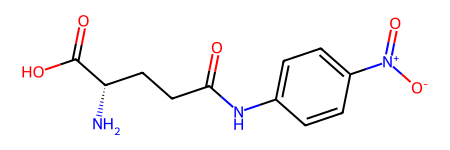

In [ ]:
Chem.MolFromSmiles(df_full['canonical_smiles'][110])

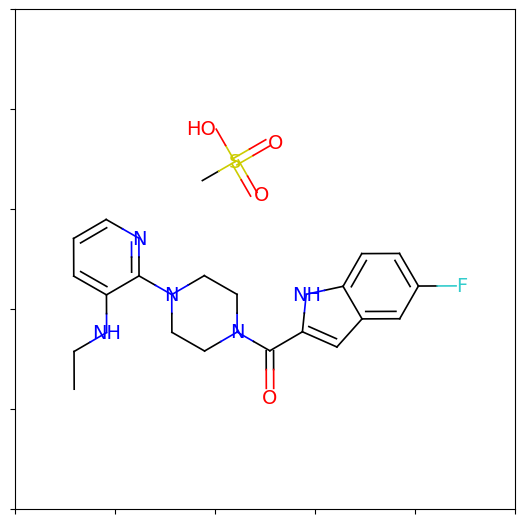

In [ ]:
mol = Chem.MolFromSmiles(df_full.canonical_smiles[1000])
Draw.MolToMPL(mol, size=(200, 200));

In [ ]:
# pytorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# create vocabulary mapping
special_chars = ["G", "E", "A"] # special tokens
all_chars = "".join(line.strip() for line in df['preprocessed_smiles'].values)
unique_chars = sorted(list(set(all_chars))).extend(special_chars)

vocab = dict((c, i) for i, c in enumerate(unique_chars))

vocab_size = len(vocab)

encoded_tensor = torch.tensor(np.array([tokenize_SMILES(s, vocab_size, vocab=vocab) for s in df['preprocessed_smiles'].values]),
                               dtype=torch.float32) # shape is (num_samples, seq_len, vocab_len)

## Creating the Dataset
[Batching Strategies](https://medium.com/analytics-vidhya/batching-strategies-for-lstm-input-6f18089b1735#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjFmNDBmMGE4ZWYzZDg4MDk3OGRjODJmMjVjM2VjMzE3YzZhNWI3ODEiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTE5MjQ4MjQyMDYyMDQwMzkxNzciLCJlbWFpbCI6InR5bGVyanBvb3JlQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3MDQ5Mjc5NDEsIm5hbWUiOiJUeWxlciBQb29yZSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NMZV81LTBIM2NWZS1CbjQ2bkZzbkpPcm9tUk1GcUpxdDNLa1VBbVBrREN1V2s9czk2LWMiLCJnaXZlbl9uYW1lIjoiVHlsZXIiLCJmYW1pbHlfbmFtZSI6IlBvb3JlIiwibG9jYWxlIjoiZW4iLCJpYXQiOjE3MDQ5MjgyNDEsImV4cCI6MTcwNDkzMTg0MSwianRpIjoiZGIyY2I3MmFlMDBhZGM2YmRmYTM4MjAwYzM5NmVlMmVhY2NlZDM2YyJ9.f4IRd8Ef2pAPUmBpxTyLhqbK2NqFxnpxWsA9DK8Jzc-izLBlaEZoVv1FOa2gZM_H4KwUt7qrmxyjW_eGzPNXiVbOfEC7lCXx7M9-GmIqTw2MVmpXsKLoNM6nnFWkED45N_wZtXpBr_8uz2zPBCEIL_dZ2oqomkpLf3V1zrZ80EyKF8y2pav_x0BDUOo9lz08SadnCDyGwMw9OrTyh9AuVwuxfLibZKtyvVJeIprN7Yp8fEkVY48bw_6IVb-o5hf5gUK6aMIPaKh1REAzXfLtt8snPaK0f4FT9PYg1CtuWRtB5Af7SCf9WLB2FyxmC_oC30UXC46pjqnTW-k2-ho5Cw)

In [ ]:
# creating the datset
class SMILESDataset(Dataset):
  def __init__(self, smiles_data, vocab, batched):
    """
    see https://github.com/judahsemi/Dino-Name-Generator
    """
    self.batched = batched
    self.encodings = []
    self.max_seqlen = float("-inf")

    # Encode SMILES

    for smiles in smiles_data:
      smiles = "G" + smiles + "E"
      encoding = [vocab[s] for s in smiles]
      self.encodings.append(encoding)
      self.max_seqlen = max(self.max_seqlen, len(encoding)-1)

  def encode_SMILES(self, smiles, vocab_size, vocab, max_len=MAX_SEQ_LEN):
    """
    Create special tokens, "G", "E", and "A" for start, end, and padding resp.
    """
    smiles = "G" + smiles + "E" + "A" * (max_len - len(smiles) - 2)
    encoded = np.zeros((max_len, len(vocab)), dtype=np.float32)

    for i, char in enumerate(smiles):
        encoded[i, vocab[char]] = 1

    return encoded


  def __len__(self):
    return len(self.encodings)

  def __getitem__(self, idx):
    # For each SMILES string, the input is all characters except the last,
    # and the target is all characters except the first (shifted by one)
    input_sequence = self.encodings[idx][:-1] # everything but last token
    target_sequence = self.encodings[idx][1:] # everything but first token
    input_len = len(input_sequence)

    pad_idx = vocab['A']

    if self.batched:
      input_sequence += ([pad_idx]*self.max_seqlen - len(input_sequence))
      target_sequence += ([pad_idx]*self.max_seqlen - len(input_sequence))

      # convert one-hot encoded targets top class indices and convert to tensors
      target_indices = torch.tensor(np.argmax(np.array(target_sequence), dim=-1)) # (seq_len, vocab_len) - > seq_len
      input_sequence = torch.tensor(np.array(input_sequence))
      input_len = torch.tensor(input_len)

    return input_sequence, input_len, target_indices


# Split data into training, validation, and testing
train_data, test_data = train_test_split(encoded_tensor, test_size=0.3)
val_data, test_data = train_test_split(test_data, test_size=0.5)

train_dataset = SMILESDataset(train_data)
val_dataset = SMILESDataset(val_data)
test_dataset = SMILESDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
best_val_loss = float('inf')

# training loop from method 2
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit='batch') as tepoch:
      for batch in tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        inputs, targets = batch  # shapes: (batch_size, seq_len-1, vocab_len), (batch_size, seq_len-1)
        optimizer.zero_grad()
        outputs = model(inputs) # shape: (batch_size, seq_len-1, vocab_len)
        loss = loss_function(outputs.transpose(1, 2), targets) # expects (vocab_len, seq_len - 1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        tepoch.set_postfix(loss=train_loss / len(train_loader))
      avg_train_loss = train_loss / len(train_loader)
      print(f"Train Loss: {avg_train_loss}")
      model.eval()
      val_loss = 0
      with torch.no_grad():
        for batch in val_loader:
          inputs, targets = batch
          outputs = model(inputs)
          loss = loss_function(outputs.transpose(1, 2), targets)
          val_loss += loss.item()

        start_token = 'G'
        start_tensor = torch.tensor(np.array([tokenize_SMILES(start_token, len(vocab), vocab)]), dtype=torch.float32)
        output = model(start_tensor).squeeze(0)  # remove batch dimension
        probabilities = torch.softmax(output[-1], dim=0)  # softmax to get probabilities
        top_probs, top_indices = torch.topk(probabilities, 5)  # get top 5 probabilities and their indices
        top_tokens = [k for k, v in vocab.items() if v in top_indices.tolist()]

        # # Print the top tokens and their probabilities
        # print("Top predictions after validation:")
        # for token, prob in zip(top_tokens, top_probs.numpy()):
        #     print(f"Token: {token}, Probability: {prob:.4f}")

      avg_val_loss = val_loss / len(val_loader)
      print(f"Validation Loss: {avg_val_loss}")

      # Print the top tokens and their probabilities
      print("Top predictions after validation:")
      for token, prob in zip(top_tokens, top_probs.numpy()):
          print(f"Token: {token}, Probability: {prob:.4f}")

      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save(model.state_dict(), '/content/drive/MyDrive/models/SMILESRNN_best.pth')

Epoch 1: 100%|██████████| 761/761 [09:02<00:00,  1.40batch/s, loss=1.04]


Train Loss: 1.038616777327935


<ipython-input-19-c13de3277da2>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  start_tensor = torch.tensor([tokenize_SMILES(start_token, len(vocab), vocab)], dtype=torch.float32)


Top predictions after validation:
Token: E, Probability: 0.9999
Token: A, Probability: 0.0000
Token: C, Probability: 0.0000
Token: c, Probability: 0.0000
Token: o, Probability: 0.0000
Validation Loss: 0.6133611359479237


Epoch 2: 100%|██████████| 761/761 [09:10<00:00,  1.38batch/s, loss=0.574]


Train Loss: 0.5736857871188441
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.511085159390982


Epoch 3: 100%|██████████| 761/761 [09:11<00:00,  1.38batch/s, loss=0.505]


Train Loss: 0.5045192954026446
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.46929307108276463


Epoch 4: 100%|██████████| 761/761 [09:04<00:00,  1.40batch/s, loss=0.471]


Train Loss: 0.47116587231726276
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Token: n, Probability: 0.0000
Validation Loss: 0.44529874613679993


Epoch 5: 100%|██████████| 761/761 [09:03<00:00,  1.40batch/s, loss=0.45]


Train Loss: 0.45004882875942526
Top predictions after validation:
Token: A, Probability: 1.0000
Token: 3, Probability: 0.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.4306232834154843


Epoch 6: 100%|██████████| 761/761 [09:03<00:00,  1.40batch/s, loss=0.435]


Train Loss: 0.43479375355190425
Top predictions after validation:
Token: A, Probability: 1.0000
Token: 3, Probability: 0.0000
Token: C, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.4171006869684699


Epoch 7: 100%|██████████| 761/761 [08:55<00:00,  1.42batch/s, loss=0.423]


Train Loss: 0.4232114491967115
Top predictions after validation:
Token: A, Probability: 1.0000
Token: C, Probability: 0.0000
Token: O, Probability: 0.0000
Token: [, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.41400616593156125


Epoch 8: 100%|██████████| 761/761 [08:54<00:00,  1.42batch/s, loss=0.414]


Train Loss: 0.41420284826088205
Top predictions after validation:
Token: A, Probability: 1.0000
Token: (, Probability: 0.0000
Token: C, Probability: 0.0000
Token: N, Probability: 0.0000
Token: c, Probability: 0.0000
Validation Loss: 0.40085993752889104


Epoch 9:  91%|█████████ | 689/761 [08:03<00:45,  1.58batch/s, loss=0.368]

In [ ]:
# Test the model
model.load_state_dict(torch.load('/content/drive/MyDrive/models/SMILESRNN_best.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs.transpose(1, 2), targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss}")

Test Loss: 0.3969599975764386


In [ ]:
# Model Sampling

sampled_smiles = sample_model(model, vocab, temperature=100)
print(sampled_smiles)


GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
